Linear regression predicts $y$ as linear combination of the predictors, $X$,

\begin{align}
\hat{y} = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_D X_D = X\beta .
\end{align}

The most common way in which this is done, is by assuming that $y$ follows a normal distribution with mean given by $X\beta$, and standard deviation $\sigma$.

\begin{align}
y \sim \mathcal{N}(X\beta, \sigma),
\end{align}

A _generalised linear model_ (GLM) involves
1. A link function, $g$, such that $\hat{y} = g^{-1}(X\beta)$ that are used to model the data.
2. A data distribution $p(y|\hat{y})$,

Just like traditional linear models have a variance parameter, a GLM may involve other parameters which we'll mention later on. Of course, linear models are a trivial special case of GLM's where the link function is the identity, $g(x) = x$, and the data distribution is the normal distribution.

But chances are you've already came across a non-trivial example of a GLM: _logistic regression_. In logistic regression, the link function is the logistic function (duh...),

\begin{align}
\mathrm{logit}^{-1}(x) = \mathrm{logistic}(x) = \frac{1}{1 + e^{-x}}
\end{align}

and the data distribution is the Bernoulli distribution because the data $y$ is binary. So we write,

\begin{align}
y \sim \mathrm{Bernoulli}\left({\mathrm{logit}^{-1}(X\beta})\right)
\end{align}


The need for a GLM appears, for example, when we try to model data on _counts_. Count data will always be integer-valued and positive, so if we use traditional linear regression, and therefore assume that the data follows a normal distribution, we are already doing something wrong since the normal distribution can take any real value.

In this series, you'll learn about 3 different GLMs:
1. __Poisson model__. This is used to model count data, where each data point can equal $0, 1, 2, ...$. 
2. __Logistic-binomial model___. This is used to model data where each point counts the number of successes out of a number of trials (the number of trials need not to be the same for each observation).
3. __Robust regression model__. Here, the usual normal distribution in a traditional linear regression is replaced with a student-t distribution. This allows for smooth handling of ocassional outliers.



In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats

In [3]:
df = pd.read_csv(
    "http://www.stat.columbia.edu/~gelman/arm/examples/police/frisk_with_noise.dat",
    skiprows=6,
    delimiter=" ",
)

In [4]:
# print(df.head().to_html())

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 6 columns):
stops           900 non-null int64
pop             900 non-null int64
past.arrests    900 non-null int64
precinct        900 non-null int64
eth             900 non-null int64
crime           900 non-null int64
dtypes: int64(6)
memory usage: 42.3 KB


In [6]:
X = (df
    .groupby(['eth', 'precinct'])[["stops", "past.arrests"]]
    .sum()
    .reset_index()
    .pipe(pd.get_dummies, columns=['eth', 'precinct'])
    .assign(intercept=1)
    .sort_values(by='stops')
    .reset_index(drop=True)
)

y = X.pop("stops")

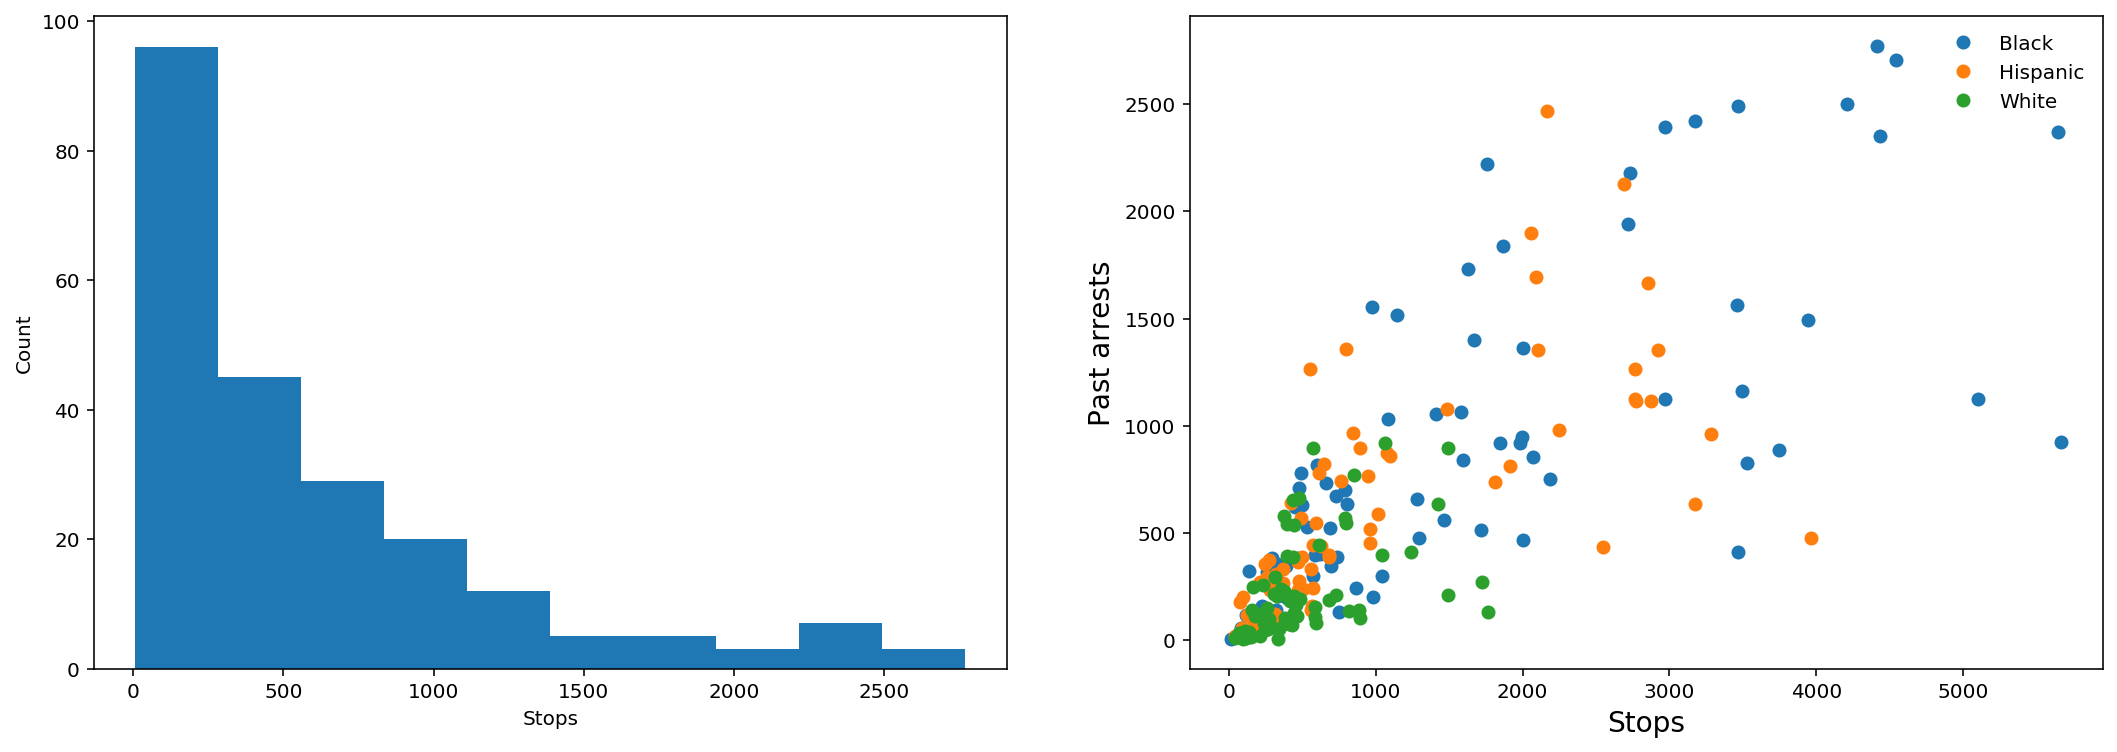

In [7]:
f, axes = plt.subplots(1, 2, figsize=(18, 6))
axes[0].hist(y)
axes[0].set_xlabel("Stops")
axes[0].set_ylabel("Count")
axes[1].plot(X.loc[X.eth_1 == 1, "past.arrests"], y.loc[X.eth_1 == 1], 'o', label="Black")
axes[1].plot(X.loc[X.eth_2 == 1, "past.arrests"], y.loc[X.eth_2 == 1], 'o', label="Hispanic")
axes[1].plot(X.loc[X.eth_3 == 1, "past.arrests"], y.loc[X.eth_3 == 1], 'o', label="White")
axes[1].set_xlabel("Stops", fontsize=14)
axes[1].set_ylabel("Past arrests", fontsize=14)
# plt.rc('font', size=14)
plt.legend(frameon=False)
plt.show()

## Poisson regression, exposure and overdispersion

In [132]:
model_no_indicators = sm.GLM(
    y,
    X["intercept"],
    offset=np.log(X["past.arrests"]),
#     family=sm.families.Poisson(),
    family=sm.families.NegativeBinomial(),
)

In [133]:
result_no_indicators = model_no_indicators.fit()

In [134]:
result_no_indicators.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  stops   No. Observations:                  225
Model:                            GLM   Df Residuals:                      224
Model Family:        NegativeBinomial   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1571.4
Date:                Thu, 21 May 2020   Deviance:                       105.28
Time:                        08:07:23   Pearson chi2:                     99.3
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.4287      0.067     -6.415      0.000      -0.560      -0.298
==============================================================================
"""

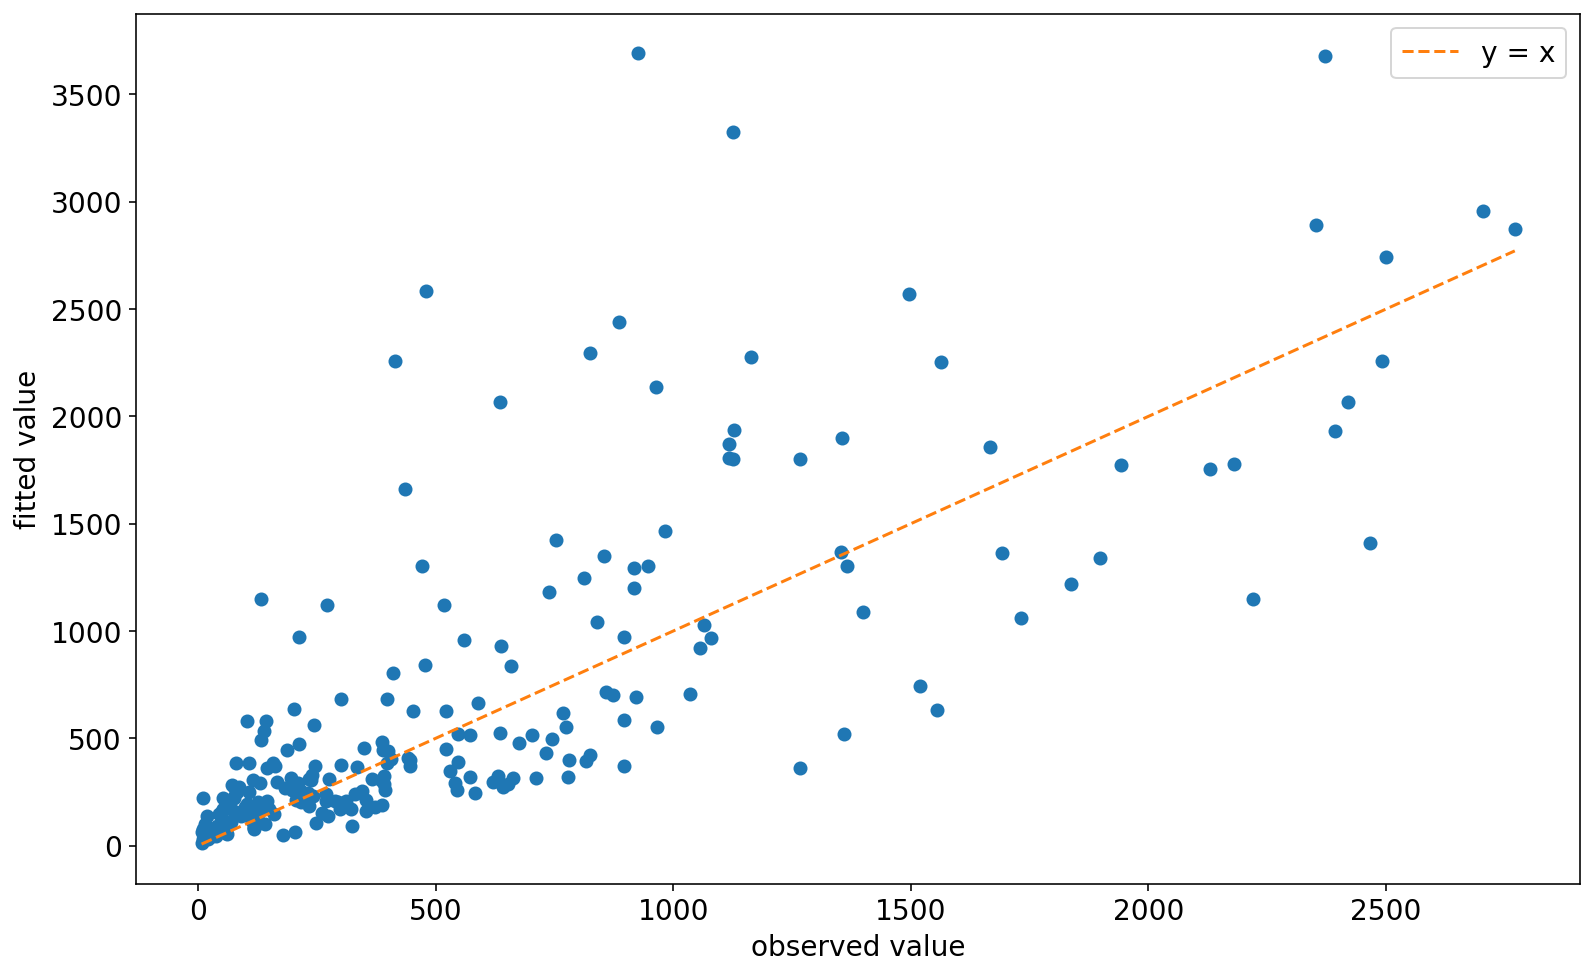

In [135]:
plt.figure(figsize=(8 * 1.618, 8))
plt.plot(y, result_no_indicators.fittedvalues, 'o')
plt.plot(y, y, '--', label='y = x')
plt.rc('font', size=14)
plt.ylabel("fitted value")
plt.xlabel("observed value")
plt.legend()
plt.show()

In [136]:
result_no_indicators.predict(np.ones_like(y), offset=np.log(X['past.arrests']))

0        10.421792
1        63.182114
2       220.160357
3        74.906630
4        28.659928
          ...     
220    1410.850096
221    2258.923422
222    2741.582665
223    2957.183487
224    2873.157789
Name: past.arrests, Length: 225, dtype: float64

In [137]:
model_with_ethnicity = sm.GLM(
    y,
    X[['intercept', 'eth_2', 'eth_3']],
    offset=np.log(X["past.arrests"]),
#     family=sm.families.Poisson(),
    family=sm.families.NegativeBinomial(),
)

In [138]:
result_with_ethnicity = model_with_ethnicity.fit()
print(result_with_ethnicity.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  stops   No. Observations:                  225
Model:                            GLM   Df Residuals:                      222
Model Family:        NegativeBinomial   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1567.9
Date:                Thu, 21 May 2020   Deviance:                       98.334
Time:                        08:08:31   Pearson chi2:                     99.0
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.3338      0.116     -2.886      0.0

In [167]:
(3.24e+03 / 148)

21.89189189189189

In [166]:
model_with_ethnicity_and_precinct = sm.GLM(
    y,
    X.drop(columns=["eth_1", "precinct_1", "past.arrests"]),
    offset=np.log(X["past.arrests"]),
    family=sm.families.NegativeBinomial(alpha=0.045),
#     family=sm.families.QuasiPoisson(),
)

result_with_ethnicity_and_precinct = model_with_ethnicity_and_precinct.fit()
print(result_with_ethnicity_and_precinct.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  stops   No. Observations:                  225
Model:                            GLM   Df Residuals:                      148
Model Family:        NegativeBinomial   Df Model:                           76
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1302.4
Date:                Thu, 21 May 2020   Deviance:                       269.74
Time:                        08:16:56   Pearson chi2:                     256.
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
eth_2           0.0091      0.036      0.255      

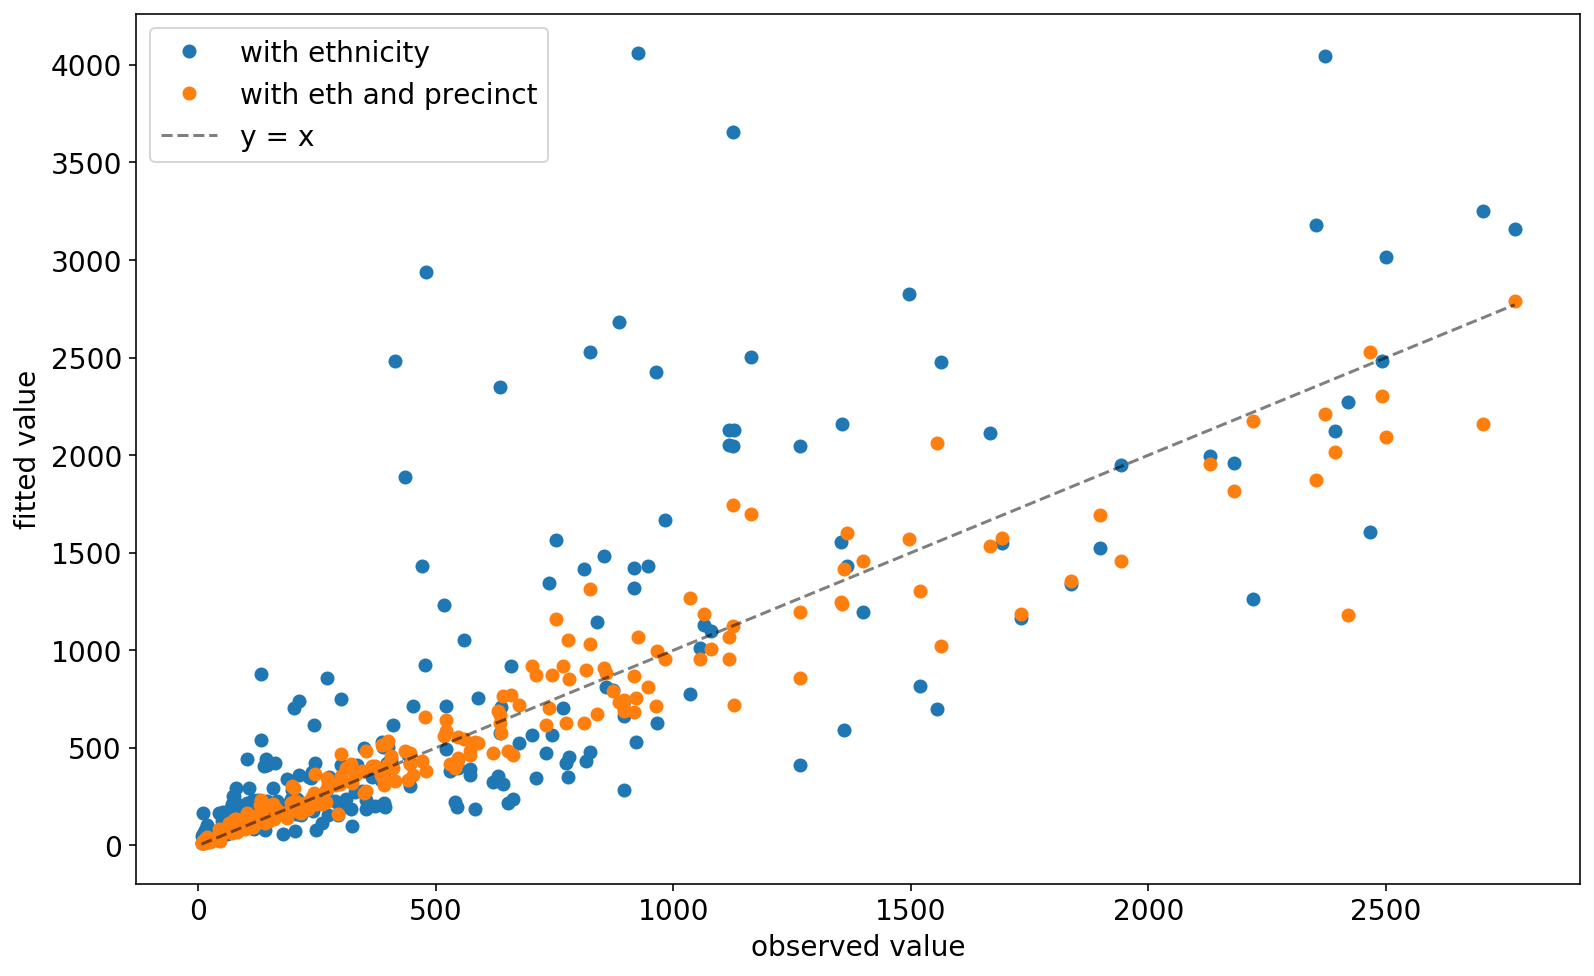

In [155]:
plt.figure(figsize=(8 * 1.618, 8))
plt.plot(y, result_with_ethnicity.fittedvalues, 'o', label='with ethnicity')
plt.plot(y, result_with_ethnicity_and_precinct.fittedvalues, 'o', label='with eth and precinct')
plt.plot(y, y, '--', label='y = x', color='black', alpha=0.5)
plt.rc('font', size=14)
plt.ylabel("fitted value")
plt.xlabel("observed value")
plt.legend()
plt.show()

In [156]:
print(f"Deviance: {result_with_ethnicity_and_precinct.deviance:.0f}")

Deviance: 30


In [157]:
result_with_ethnicity_and_precinct.pearson_chi2 / result_with_ethnicity_and_precinct.df_resid

0.1926370889406267

(array([10., 27., 44., 52., 55., 29.,  4.,  1.,  2.,  1.]),
 array([-0.82289309, -0.59231892, -0.36174475, -0.13117058,  0.09940359,
         0.32997776,  0.56055193,  0.7911261 ,  1.02170027,  1.25227444,
         1.48284861]),
 <a list of 10 Patch objects>)

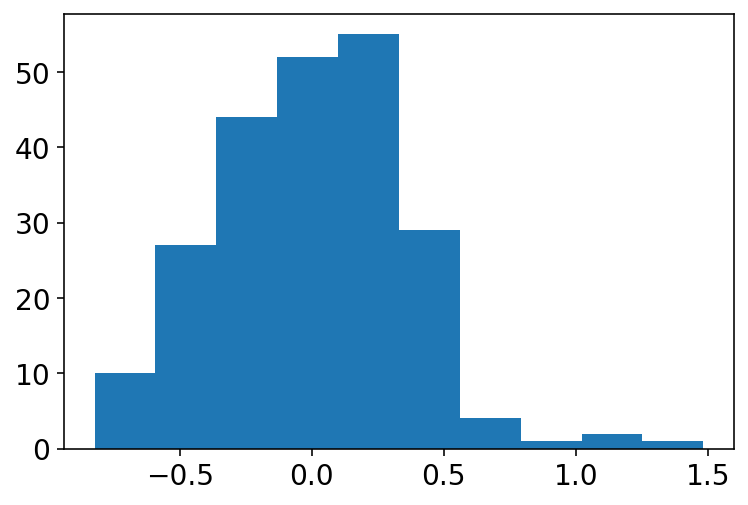

In [158]:
plt.hist(result_with_ethnicity_and_precinct.resid_pearson)

In [117]:
result_with_ethnicity_and_precinct.

eth_2          0.004101
eth_3         -0.498216
precinct_2    -0.245802
precinct_3     0.568941
precinct_4     0.935088
                 ...   
precinct_72    1.356256
precinct_73    0.795129
precinct_74    0.942388
precinct_75    1.013789
intercept     -1.204560
Length: 77, dtype: float64

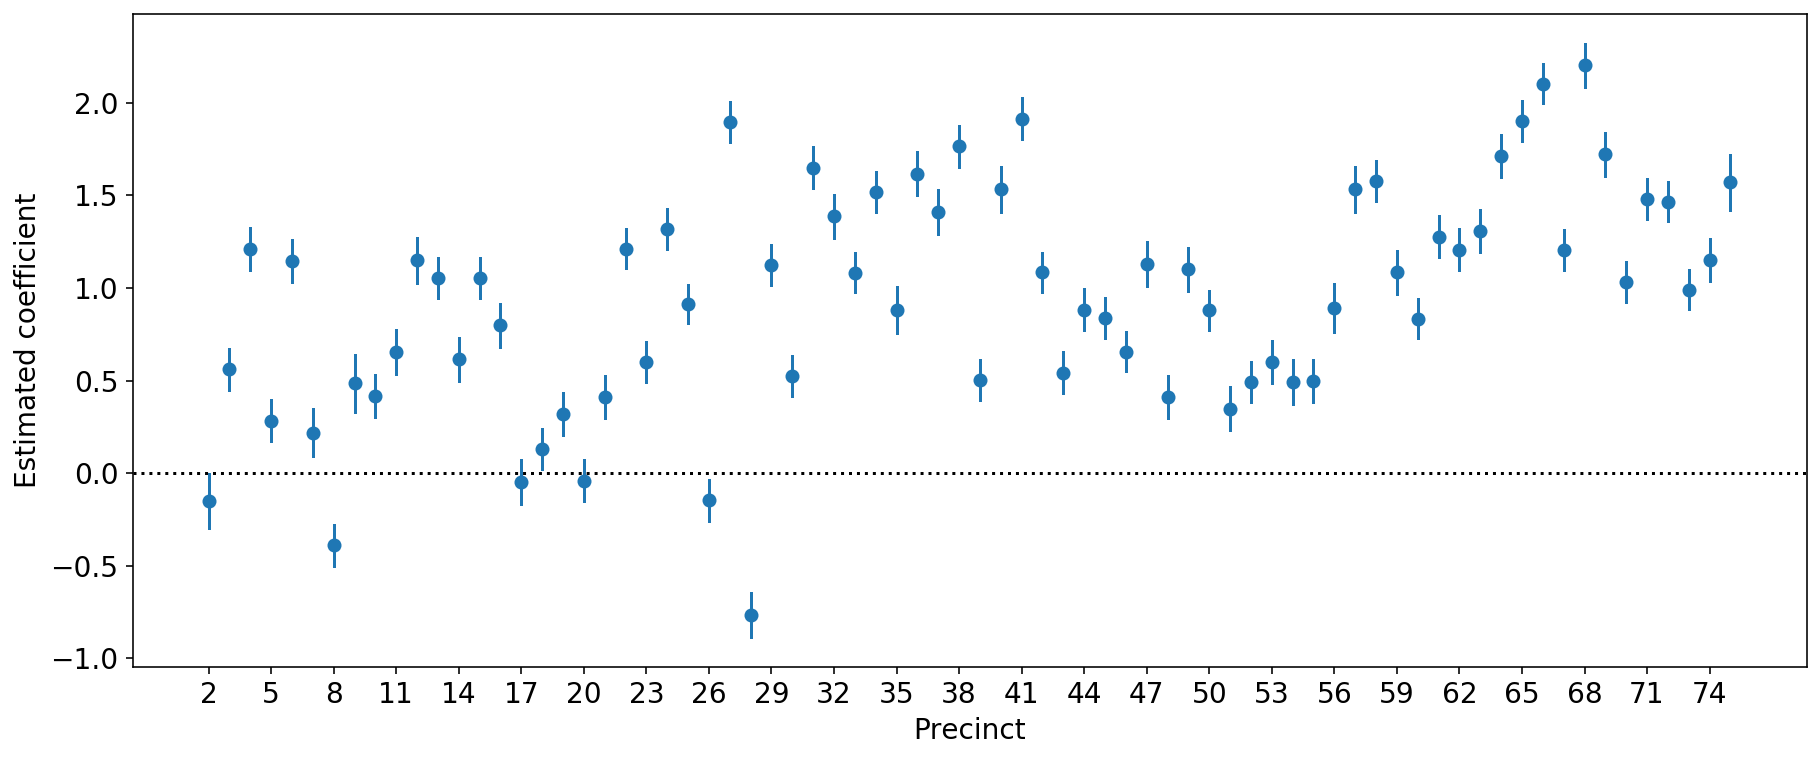

In [104]:
precinct_coefs = result_with_ethnicity_and_precinct.params.iloc[2:-1]
precinct_interval = result_with_ethnicity_and_precinct.conf_int().reindex(precinct_coefs.index)

plt.figure(figsize=(15, 6))
plt.plot(precinct_coefs, 'o')
for precinct, interval in precinct_interval.iterrows():
    plt.plot([precinct, precinct], interval, color='C0')
plt.axhline(y=0, linestyle=':', color='black')
plt.xticks(
    precinct_coefs.index[::3],
    [int(x[1]) for x in precinct_coefs.index.str.split("_",)][::3]
)
plt.ylabel("Estimated coefficient", fontsize=14)
plt.xlabel("Precinct", fontsize=14)
plt.show()

(array([0.00188637, 0.00330114, 0.00848866, 0.03206826, 0.02735234,
        0.01603413, 0.01084662, 0.00377274, 0.00188637, 0.00047159]),
 array([-39.6271479 , -30.20280686, -20.77846582, -11.35412478,
         -1.92978373,   7.49455731,  16.91889835,  26.34323939,
         35.76758043,  45.19192148,  54.61626252]),
 <a list of 10 Patch objects>)

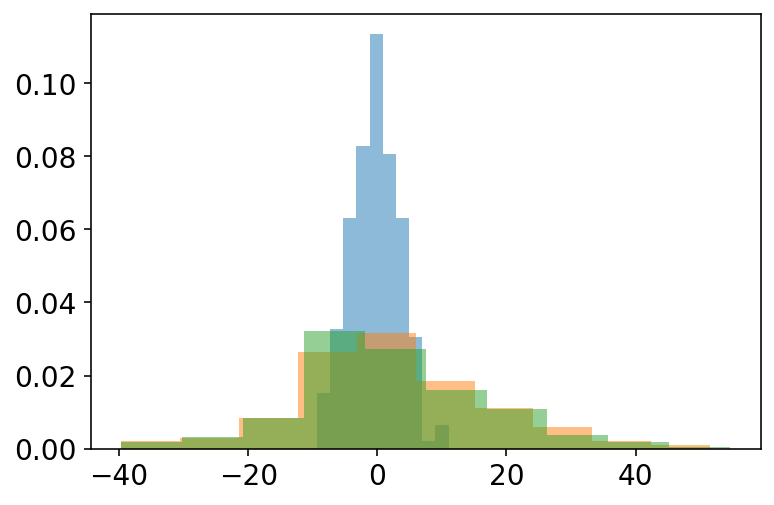

In [87]:
plt.hist(result_with_ethnicity_and_precinct.resid_pearson, density=True, alpha=0.5)
plt.hist(result_with_ethnicity.resid_pearson, density=True, alpha=0.5)
plt.hist(result_no_indicators.resid_pearson, density=True, alpha=0.5)

In [38]:
print(result_with_ethnicity_and_precinct.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  stops   No. Observations:                  225
Model:                            GLM   Df Residuals:                      148
Model Family:                 Poisson   Df Model:                           76
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2566.9
Date:                Thu, 21 May 2020   Deviance:                       3427.1
Time:                        05:45:12   Pearson chi2:                 3.24e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
eth_2           0.0102      0.007      1.498      

### Overdispersion

In [17]:
def group_residuals(y_true, y_pred, n_groups=20, offset=0):
    residuals = y_true - y_pred
    quantiles = pd.qcut(y_true, n_groups, labels=False)
    groups = residuals.groupby(quantiles)
    mean = groups.mean()
    std = groups.std()
    return mean.index + offset, mean.values, std.values

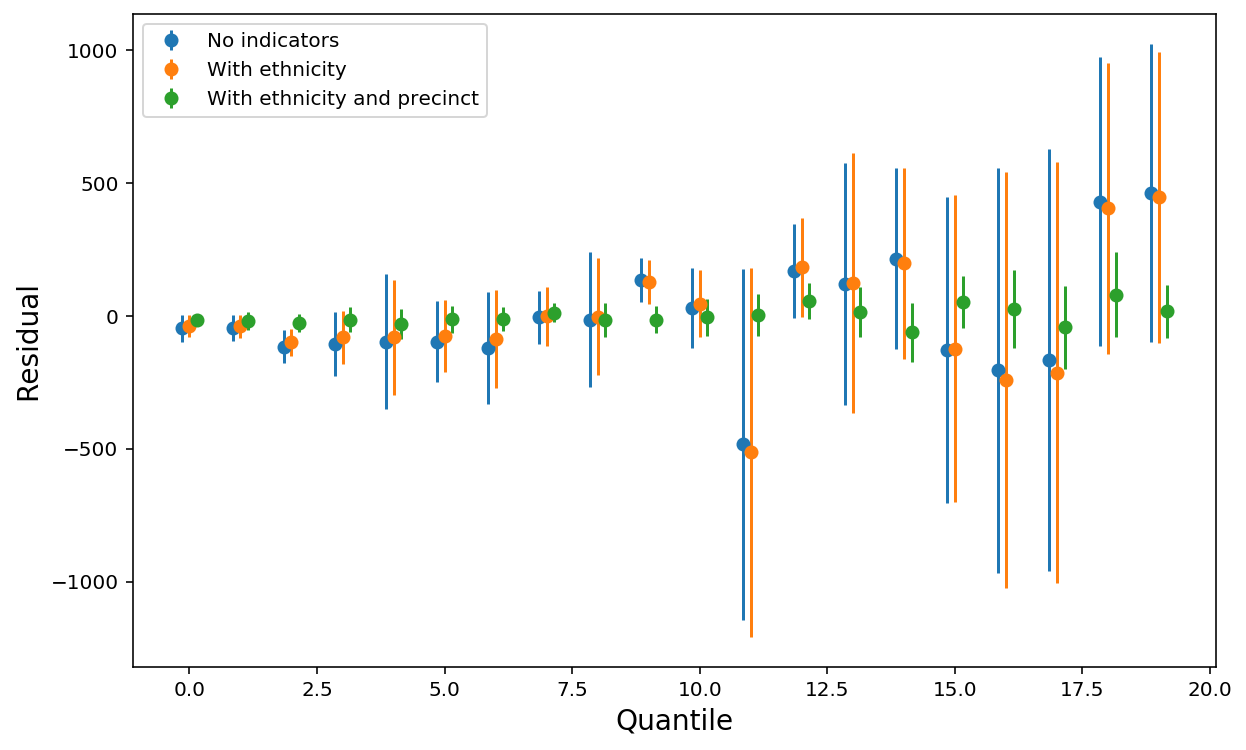

In [18]:
f = plt.figure(figsize=(6 * 1.618, 6))
plt.errorbar(
    *group_residuals(df2.stops, result_no_indicators.fittedvalues, offset=-0.15),
    label='No indicators',
    marker='o',
    linestyle=''
)
plt.errorbar(
    *group_residuals(df2.stops, result_with_ethnicity.fittedvalues),
    label='With ethnicity',
    marker='o',
    linestyle=''
)
plt.errorbar(
    *group_residuals(df2.stops, result_with_ethnicity_and_precinct.fittedvalues, offset=0.15),
    label='With ethnicity and precinct',
    marker='o',
    linestyle=''
)

plt.xlabel("Quantile", fontsize=14)
plt.ylabel("Residual", fontsize=14)
plt.legend(loc='upper left')
plt.show()

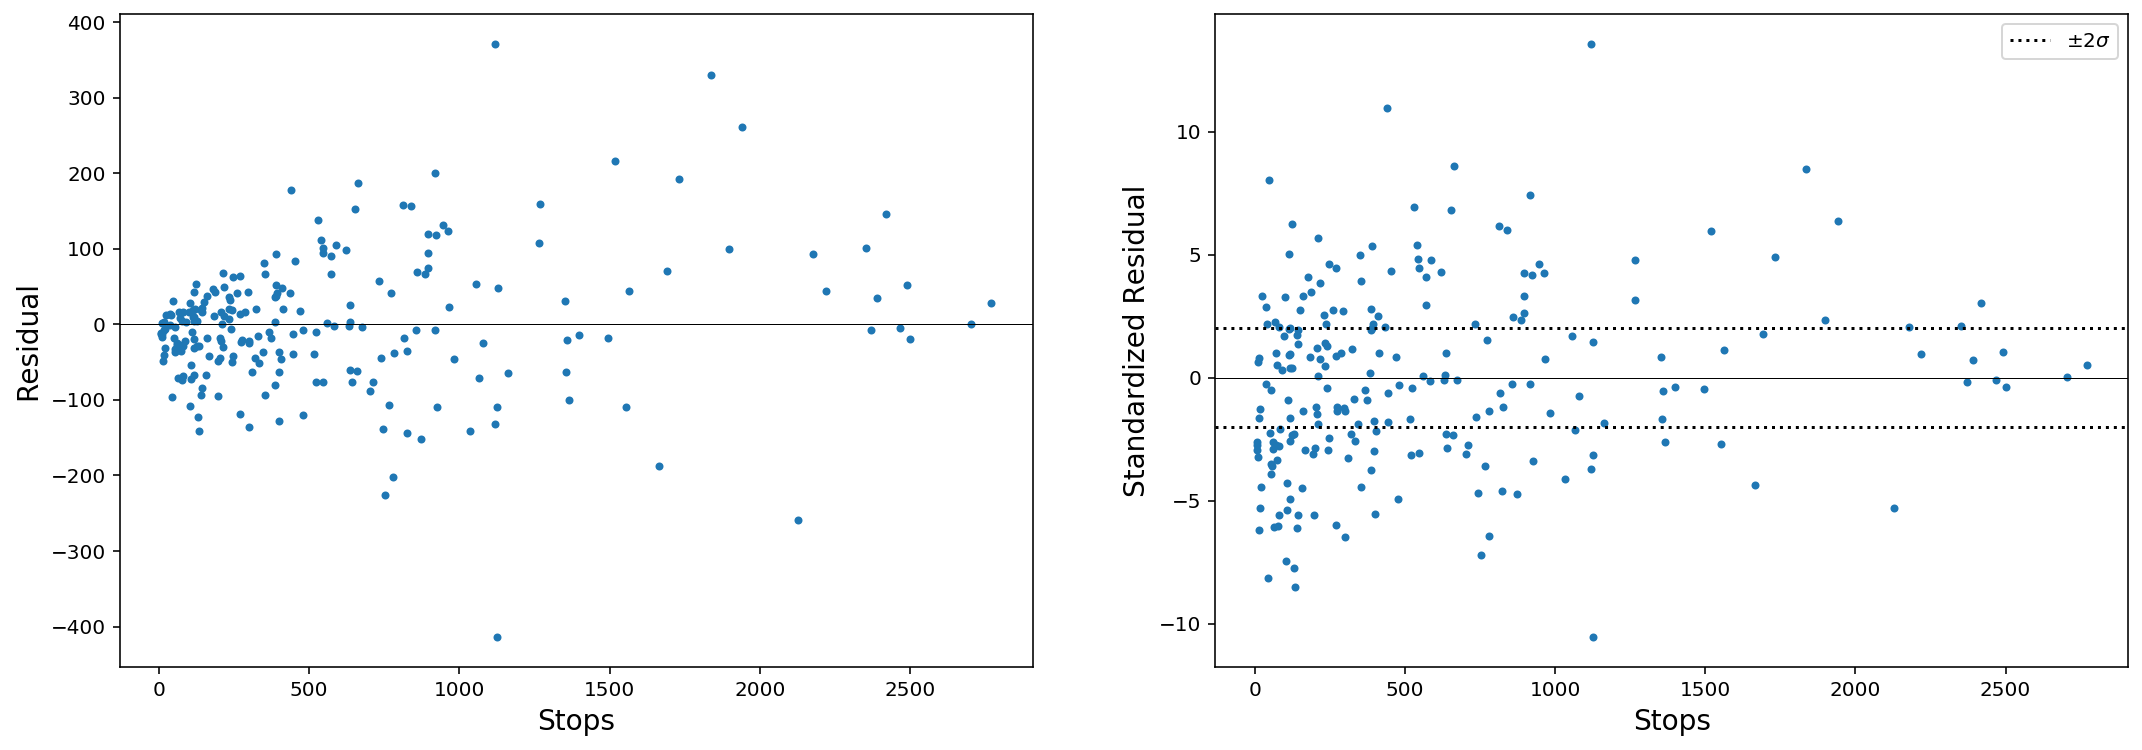

In [19]:
f, axes = plt.subplots(1, 2, figsize=(18, 6))
axes[0].plot(
    df2.stops,
    df2.stops - result_with_ethnicity_and_precinct.fittedvalues,
    marker='.',
    linestyle=''
)
axes[0].axhline(y=0, color='black', linewidth=0.5)
axes[0].set_ylabel("Residual", fontsize=14)
axes[0].set_xlabel("Stops", fontsize=14)

axes[1].plot(
    df2.stops,
    (df2.stops - result_with_ethnicity_and_precinct.fittedvalues) / np.sqrt(result_with_ethnicity_and_precinct.fittedvalues),
    marker='.',
    linestyle=''
)

axes[1].axhline(y=-2, linestyle=':', color='black', label="$\pm 2\sigma$")
axes[1].axhline(y=+2, linestyle=':', color='black',)
axes[1].axhline(y=0, color='black', linewidth=0.5)
axes[1].set_ylabel("Standardized Residual", fontsize=14)
axes[1].set_xlabel("Stops", fontsize=14)
axes[1].legend()


plt.show()

The standardised residuals are already stored in the fitted model in the attribute `resid_pearson`, so we don't need to compute these by hand.

In [20]:
z_residuals = (df2.stops - result_with_ethnicity_and_precinct.fittedvalues) / np.sqrt(result_with_ethnicity_and_precinct.fittedvalues)
(z_residuals == result_with_ethnicity_and_precinct.resid_pearson).all()

True

In [21]:
overdispersion_ratio = sum(result_with_ethnicity_and_precinct.resid_pearson ** 2) / result_with_ethnicity_and_precinct.df_resid
overdispersion_test = scipy.stats.chisquare(
    result_with_ethnicity_and_precinct.resid_pearson,
    ddof=result_with_ethnicity_and_precinct.df_resid,
)

In [22]:
print(f"Overdispersion ratio is {overdispersion_ratio:.2f}")
print(f"p-value of overdispersion test is {overdispersion_test.pvalue:.2f}")

Overdispersion ratio is 21.24
p-value of overdispersion test is 1.00
